## Motion correction with micron-size voxels using ANTs

We noticed in preliminary analyses that `ants.motion_correction()` sometimes failed badly on 2-photon imaging data (resolution: 3x3x5 microns).  This notebook examines the reason for this problem.

Summary:
- `ants.motion_correction` fails intermittently but catastrophically when it is used with data where the nifti pixel dimensions are specified in their actual size in millimeters and nifti xyz unit is set to millimeters, and when used with data where the header values are specified in their actual size in microns and the nifti xyz unit is changed to microns.  
- It does not appear to fail when the voxel sizes are specified as the micron values but the xyz unit is set to millimeters (i.e. incorrect header information).


In [1]:
import ants
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import sys
from timeit import default_timer as timer

basedir = '/Users/poldrack/data_unsynced/brainsss/ants_example_data'

# set some ANTs parameters
total_sigma = 0
flow_sigma = 3
rigid_transform = 'Rigid'

In [2]:
ants.__version__

'0.3.2'

In [3]:
# setup utility functions

def plot_image_means(antsimg, slice_to_show=20):
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    imgmeans = antsimg.mean(axis=(0,1,2))
    plt.plot(imgmeans)
    plt.ylabel('total image mean')
    plt.subplot(1,3,2)
    plt.imshow(
        antsimg[:,:,slice_to_show, np.argmin(imgmeans)],
        cmap='gray')
    plt.title('signal from lowest mean timepoint')
    plt.subplot(1,3,3)
    plt.imshow(
        antsimg[:,:,slice_to_show, np.argmax(imgmeans)],
        cmap='gray')
    plt.title('signal from highest mean timepoint')

def compute_similarity_to_mean(img, meanimg, metric_type='Correlation'):
    simvals = np.zeros(img.shape[3])
    for idx in range(img.shape[3]):
        simvals[idx] = ants.image_similarity(
            ants.utils.slice_image(img, axis=3, idx=idx),
            meanimg, metric_type=metric_type)
        if 'Correlation' in metric_type:
            simvals[idx] *= -1
    return(simvals)

def compute_timeseries_similarity(img1, img2, metric_type='Correlation'):
    assert img1.shape == img2.shape, 'images must have identical shape'
    return np.corrcoef(img1[:,:,:,:].flatten(),img2[:,:,:,:].flatten())

def plot_motpars(motpars):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(motpars[:,:3])
    plt.title('Translation (microns)')
    plt.legend(['x','y','z'])
    plt.subplot(1,2,2)
    plt.plot(motpars[:,3:])
    plt.title('Rotation (degrees)')
    plt.legend(['x','y','z'])


def get_filenames(size, units, basedir):
    assert size in ['um', 'mm'], 'size must be um or mm'
    assert units in ['um', 'mm'], 'units must be um or mm'

    fname = os.path.join(
        basedir, 
        f'series-tdtomato_size-{size}_units-{units}.nii')
    meanfname = fname.replace('.nii', '_mean.nii')
    return(fname, meanfname)


def ants_affine_to_distance(affine):
    """by @dangom, https://github.com/ANTsX/ANTsPy/issues/71"""
    dx, dy, dz = affine[9:]

    rot_x = np.arcsin(affine[6])
    cos_rot_x = np.cos(rot_x)
    rot_y = np.arctan2(affine[7] / cos_rot_x, affine[8] / cos_rot_x)
    rot_z = np.arctan2(affine[3] / cos_rot_x, affine[0] / cos_rot_x)

    deg = np.degrees

    return dx, dy, dz, deg(rot_x), deg(rot_y), deg(rot_z)



def get_motion_parameters_from_transforms(transformlist, resolution=None):
    """only gets rigid body transform parameters

    transformlist: list of transform files
    resolution: unused, vestigial"""
    transform_parameters = np.zeros((len(transformlist), 12))
    motion_parameters = np.zeros((len(transformlist), 6))
    for idx, t in enumerate(transformlist):
        if isinstance(t, list):
            paramfile = [i for i in t if i.endswith("0GenericAffine.mat")][0]
        elif t.endswith("0GenericAffine.mat"):
            paramfile = t
        else:
            raise ValueError("transformlist must contain ANTS affine matrix files")
        temp = ants.read_transform(paramfile)
        transform_parameters[idx, :] = temp.parameters
        motion_parameters[idx, :] = ants_affine_to_distance(temp.parameters)
    return transform_parameters, motion_parameters


### Data setup

We will use a small test dataset here to reduce processing times.
The actual data have a resolution of 2.61 x 2.61 x 5 microns.

File are named using the following convention:

series-tdtomato_size-{actual units specified in pixdim}_units-{units specfied for xyzt_units}.nii

e.g., `series-tdtomato_size-um_units-mm.nii` refers to a file with xyz units specified as mm, and with the following affine:

| 2.61 | 0    | 0 | 0 |
|------|------|---|---|
| 0    | 2.61 | 0 | 0 |
| 0    | 0    | 5.0 | 0 |
| 0    | 0    |   | 1 |

Whereas `series-tdtomato_size-mm_units-mm.nii` refers to a file with xyz units specified as microns, and with the following affine:

| .00261 | 0    | 0 | 0 |
|------|------|---|---|
| 0    | .00261 | 0 | 0 |
| 0    | 0    | .0050 | 0 |
| 0    | 0    |   | 1 |

## Motion correction with correctly specified metadata values in microns

In [4]:
origfile, meanfile = get_filenames(
    'um', 'um', basedir)

origimg = nib.load(origfile)
meanimg = nib.load(meanfile)

print(origimg.affine)
print(origimg.header.get_xyzt_units())


[[2.61120129 0.         0.         0.        ]
 [0.         2.61114621 0.         0.        ]
 [0.         0.         5.         0.        ]
 [0.         0.         0.         1.        ]]
('micron', 'unknown')


Note that when the units are specified as microns, ANTs will automatically change the spacing to (correct) millimeter values.

In [5]:
# create ANTs versions of data

orig_ants_um_um = ants.from_nibabel(origimg)
mean_ants_um_um = ants.from_nibabel(meanimg)
orig_ants_um_um

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 49, 57)
	 Spacing    : (0.0026, 0.0026, 0.005, 0.532)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

In [6]:
moco_um_um = ants.motion_correction(
    image=orig_ants_um_um,
    fixed=mean_ants_um_um,
    verbose=True,
    type_of_transform=rigid_transform,
    total_sigma=total_sigma,
    flow_sigma=flow_sigma)


Progress:
0%.Done


If we plot the image means at each timepoint, we see that there are a number of timepoints where the mean is very low, which reflects the fact that the brain has been largely translated out of the frame and most voxels are empty.

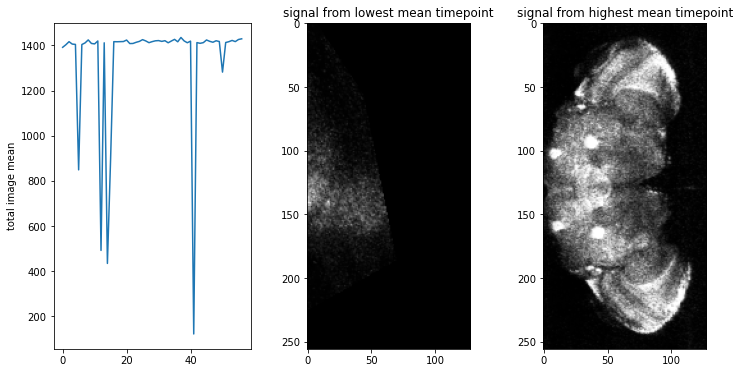

In [7]:
plot_image_means(moco_um_um['motion_corrected'])

If we rerun it again we see that there will be different time points dropped out, suggesting that this issue may have to do with random initialization in the registration process.

In [8]:
moco_um_um_rerun = ants.motion_correction(
    image=orig_ants_um_um,
    fixed=mean_ants_um_um,
    verbose=True,
    type_of_transform=rigid_transform,
    total_sigma=total_sigma,
    flow_sigma=flow_sigma)


Progress:
0%.Done


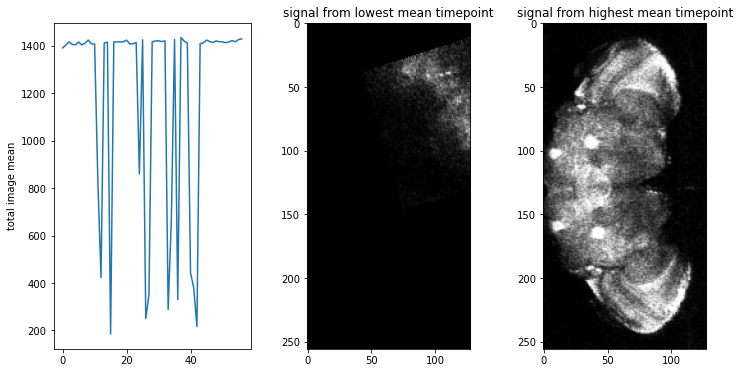

In [9]:
plot_image_means(moco_um_um_rerun['motion_corrected'])

## Motion correction with correctly specified metadata values in millimeters

In [10]:
origfile, meanfile = get_filenames(
    'mm', 'mm', basedir)

origimg = nib.load(origfile)
meanimg = nib.load(meanfile)

print(origimg.affine)
print(origimg.header.get_xyzt_units())


[[0.0026112  0.         0.         0.        ]
 [0.         0.00261115 0.         0.        ]
 [0.         0.         0.005      0.        ]
 [0.         0.         0.         1.        ]]
('mm', 'sec')


In [11]:
# create ANTs versions of data

orig_ants_mm_mm = ants.from_nibabel(origimg)
mean_ants_mm_mm = ants.from_nibabel(meanimg)
orig_ants_mm_mm

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 49, 57)
	 Spacing    : (0.0026, 0.0026, 0.005, 0.532)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

In [12]:
moco_mm_mm = ants.motion_correction(
    image=orig_ants_mm_mm,
    fixed=mean_ants_mm_mm,
    verbose=True,
    type_of_transform=rigid_transform,
    total_sigma=total_sigma,
    flow_sigma=flow_sigma)


Progress:
0%.Done


Here we see a similar failure to the one observed above.

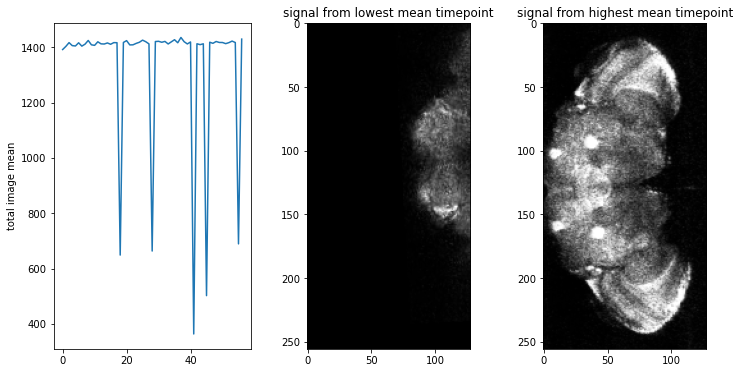

In [13]:
plot_image_means(moco_mm_mm['motion_corrected'])

## Motion correction with incorrectly specified metadata values


Here we specify the pixel dimensions in their micron values, but specify the xyz units as mm.

In [14]:
origfile, meanfile = get_filenames(
    'um', 'mm', basedir)

origimg = nib.load(origfile)
meanimg = nib.load(meanfile)

print(origimg.affine)
print(origimg.header.get_xyzt_units())


[[2.61120129 0.         0.         0.        ]
 [0.         2.61114621 0.         0.        ]
 [0.         0.         5.         0.        ]
 [0.         0.         0.         1.        ]]
('mm', 'sec')


In [15]:
# create ANTs versions of data

orig_ants_um_mm = ants.from_nibabel(origimg)
mean_ants_um_mm = ants.from_nibabel(meanimg)
orig_ants_um_mm

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 49, 57)
	 Spacing    : (2.6112, 2.6111, 5.0, 0.532)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

In [16]:
moco_um_mm = ants.motion_correction(
    image=orig_ants_um_mm,
    fixed=mean_ants_um_mm,
    verbose=True,
    type_of_transform=rigid_transform,
    total_sigma=total_sigma,
    flow_sigma=flow_sigma)


Progress:
0%.Done


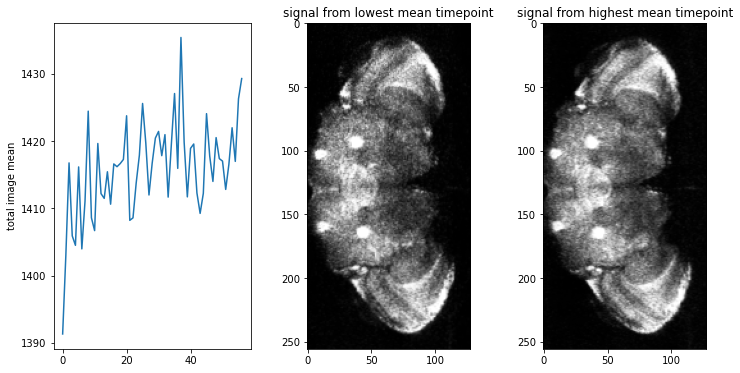

In [17]:
plot_image_means(moco_um_mm['motion_corrected'])

Looking at the motion parameters we see that they seem fairly reasonable.

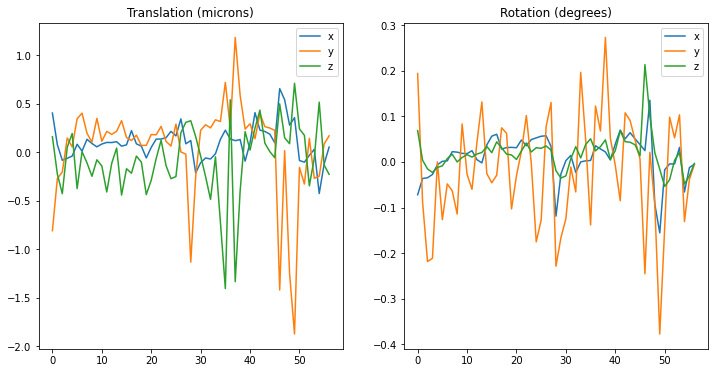

In [18]:
motpar = get_motion_parameters_from_transforms(moco_um_mm['motion_parameters'])[1]
plot_motpars(motpar)